# Cosine Benchmark

This notebook benchmarks cosine synthetic data across multiple seeds to estimate
mean and standard deviation for each model. It reports MSE, RMSE, MAE, MAPE, and
parameter counts for KAN, ARIMA, Linear, Decision Tree, RNN, and TIMEVIEW.


In [81]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

repo_root = Path.cwd().parent
sys.path.append(str(repo_root))

from synt_data.generate_cos_data import generate_cos_dataset

from mckan_pykan.config import MCKANPyKANConfig
from mckan_pykan.data import MCKANDataset
from mckan_pykan.data import create_train_val_test_dataloaders as create_kan_loaders
from mckan_pykan.training import training as kan_training

from timeview.config import Config as TTSConfig
from timeview.data import TTSDataset
from timeview.data import create_train_val_test_dataloaders as create_tts_loaders
from timeview.training import training as tts_training

try:
    from statsmodels.tsa.arima.model import ARIMA
except Exception as exc:
    print('ARIMA not available:', exc)
    ARIMA = None


In [82]:
def prepare_static_history_from_df(df, history_end=1.0):
    static_cols = [c for c in df.columns if c not in ('trajectory_id', 't', 'y')]
    trajectory_ids = sorted(df['trajectory_id'].unique())

    X_static = (
        df.drop_duplicates('trajectory_id')
        .sort_values('trajectory_id')[static_cols]
        .to_numpy()
    )

    Zs, ts, ys_list = [], [], []
    for tid in trajectory_ids:
        traj = df[df['trajectory_id'] == tid].sort_values('t')
        t_vals = traj['t'].to_numpy()
        y_vals = traj['y'].to_numpy()

        hist_mask = t_vals <= history_end
        pred_mask = t_vals > history_end

        Zs.append(y_vals[hist_mask].reshape(-1, 1))
        ts.append(t_vals[pred_mask].copy())
        ys_list.append(y_vals[pred_mask].copy())

    return X_static, Zs, ts, ys_list


def mse(a, b):
    return float(np.mean((a - b) ** 2))


def rmse(a, b):
    return float(np.sqrt(mse(a, b)))


def mae(a, b):
    return float(np.mean(np.abs(a - b)))


def mape(a, b, eps=1e-8):
    return float(np.mean(np.abs((a - b) / (np.abs(b) + eps))))


def count_params_torch(model):
    return int(sum(p.numel() for p in model.parameters()))


def eval_loader_metrics(model, loader):
    mse_vals, mae_vals, mape_vals = [], [], []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            Xb, Zb, Phis, yb = batch
            preds = model(Xb, Zb, Phis)
            for pred, y in zip(preds, yb):
                pred_np = pred.cpu().numpy()
                y_np = y.cpu().numpy()
                mse_vals.append(mse(pred_np, y_np))
                mae_vals.append(mae(pred_np, y_np))
                mape_vals.append(mape(pred_np, y_np))
    mse_mean = float(np.mean(mse_vals))
    mae_mean = float(np.mean(mae_vals))
    mape_mean = float(np.mean(mape_vals))
    rmse_mean = float(np.sqrt(mse_mean))
    return mse_mean, rmse_mean, mae_mean, mape_mean


def eval_tts_metrics(model, loader):
    mse_vals, mae_vals, mape_vals = [], [], []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            Xb, Phis, yb = batch
            preds = model(Xb, Phis)
            for pred, y in zip(preds, yb):
                pred_np = pred.cpu().numpy()
                y_np = y.cpu().numpy()
                mse_vals.append(mse(pred_np, y_np))
                mae_vals.append(mae(pred_np, y_np))
                mape_vals.append(mape(pred_np, y_np))
    mse_mean = float(np.mean(mse_vals))
    mae_mean = float(np.mean(mae_vals))
    mape_mean = float(np.mean(mape_vals))
    rmse_mean = float(np.sqrt(mse_mean))
    return mse_mean, rmse_mean, mae_mean, mape_mean


In [83]:
seeds = [0, 1, 2]
history_end = 1.0
T = 2.0
n_samples = 200
n_points = 40

dataset_split = {'train': 0.8, 'val': 0.1, 'test': 0.1}

kan_widths = [16, 16]
kan_grid = 6
kan_n_basis = 8
kan_epochs = 150

tts_n_basis = 8
tts_epochs = 150

rnn_hidden_dim = 32
rnn_epochs = 200
rnn_batch_size = 32

arima_order = (2, 0, 0)

In [84]:
class SimpleGRU(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, out_dim=20):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.head = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        return self.head(last)


def train_rnn(X_train, Y_train, X_val, Y_val, seed, hidden_dim=32, epochs=200, batch_size=32):
    device = torch.device('cpu')
    torch.manual_seed(seed)
    model = SimpleGRU(input_dim=X_train.shape[-1], hidden_dim=hidden_dim, out_dim=Y_train.shape[-1]).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    model.train()
    for _ in range(epochs):
        for xb, yb in train_loader:
            optim.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optim.step()

    return model


In [85]:
def run_all_models_for_seed(seed):
    df = generate_cos_dataset(n_samples=n_samples, n_points=n_points, seed=seed, T=T)
    X_static, Zs, ts, ys_list = prepare_static_history_from_df(df, history_end=history_end)

    rng = np.random.default_rng(seed)
    N = X_static.shape[0]
    indices = rng.permutation(N)
    n_train = int(dataset_split['train'] * N)
    n_val = int(dataset_split['val'] * N)
    train_idx = indices[:n_train]
    val_idx = indices[n_train:n_train + n_val]
    test_idx = indices[n_train + n_val:]

    results = []

    np.random.seed(seed)
    torch.manual_seed(seed)

    # KAN (MC-KAN)
    history_len = Zs[0].shape[0]
    dynamic_feature_dim = Zs[0].shape[1]
    n_dynamic_features = history_len * dynamic_feature_dim

    kan_cfg = MCKANPyKANConfig(
        n_static_features=X_static.shape[1],
        n_dynamic_features=n_dynamic_features,
        n_basis=kan_n_basis,
        T=T,
        seed=seed,
        dataset_split=dataset_split,
        dynamic_mode='history',
        num_epochs=kan_epochs,
        kan={
            'widths': list(kan_widths),
            'grid': kan_grid,
            'degree': 3,
            'kwargs': {},
        },
    )

    kan_dataset = MCKANDataset(kan_cfg, (X_static, Zs, ts, ys_list))
    kan_lit = kan_training(kan_cfg.seed, kan_cfg, kan_dataset)
    _, _, kan_test = create_kan_loaders(kan_cfg, kan_dataset)
    kan_mse, kan_rmse, kan_mae, kan_mape = eval_loader_metrics(kan_lit.model, kan_test)
    kan_params = count_params_torch(kan_lit.model)

    results.append({
        'Seed': seed,
        'Model': f'KAN widths={kan_widths} grid={kan_grid} n_basis={kan_n_basis}',
        'MSE': kan_mse,
        'RMSE': kan_rmse,
        'MAE': kan_mae,
        'MAPE': kan_mape,
        'Parameters': kan_params,
    })

    # Linear + Decision Tree
    X_hist = np.stack([z.reshape(-1) for z in Zs])
    X_base = np.concatenate([X_static, X_hist], axis=1)
    Y_base = np.stack(ys_list)

    X_train, Y_train = X_base[train_idx], Y_base[train_idx]
    X_val, Y_val = X_base[val_idx], Y_base[val_idx]
    X_test, Y_test = X_base[test_idx], Y_base[test_idx]

    lin = LinearRegression()
    lin.fit(X_train, Y_train)
    y_lin = lin.predict(X_test)
    lin_params = int(lin.coef_.size + lin.intercept_.size)

    results.append({
        'Seed': seed,
        'Model': 'Linear',
        'MSE': mse(y_lin, Y_test),
        'RMSE': rmse(y_lin, Y_test),
        'MAE': mae(y_lin, Y_test),
        'MAPE': mape(y_lin, Y_test),
        'Parameters': lin_params,
    })

    tree = DecisionTreeRegressor(random_state=seed)
    tree.fit(X_train, Y_train)
    y_tree = tree.predict(X_test)
    tree_params = int(tree.tree_.node_count)

    results.append({
        'Seed': seed,
        'Model': 'DecisionTree',
        'MSE': mse(y_tree, Y_test),
        'RMSE': rmse(y_tree, Y_test),
        'MAE': mae(y_tree, Y_test),
        'MAPE': mape(y_tree, Y_test),
        'Parameters': tree_params,
    })

    # RNN
    X_hist_seq = np.stack(Zs)
    X_static_seq = X_static[:, None, :]
    X_static_seq = np.repeat(X_static_seq, X_hist_seq.shape[1], axis=1)
    X_seq = np.concatenate([X_hist_seq, X_static_seq], axis=2)
    Y_seq = np.stack(ys_list)

    X_train_seq, Y_train_seq = X_seq[train_idx], Y_seq[train_idx]
    X_val_seq, Y_val_seq = X_seq[val_idx], Y_seq[val_idx]
    X_test_seq, Y_test_seq = X_seq[test_idx], Y_seq[test_idx]

    rnn = train_rnn(X_train_seq, Y_train_seq, X_val_seq, Y_val_seq, seed=seed, hidden_dim=rnn_hidden_dim, epochs=rnn_epochs, batch_size=rnn_batch_size)
    with torch.no_grad():
        y_rnn = rnn(torch.from_numpy(X_test_seq).float()).cpu().numpy()
    rnn_params = count_params_torch(rnn)

    results.append({
        'Seed': seed,
        'Model': 'RNN',
        'MSE': mse(y_rnn, Y_test_seq),
        'RMSE': rmse(y_rnn, Y_test_seq),
        'MAE': mae(y_rnn, Y_test_seq),
        'MAPE': mape(y_rnn, Y_test_seq),
        'Parameters': rnn_params,
    })

    # TIMEVIEW/TTS baseline (static-only)
    tts_cfg = TTSConfig(
        n_features=X_static.shape[1],
        n_basis=tts_n_basis,
        T=T,
        seed=seed,
        dataset_split=dataset_split,
        num_epochs=tts_epochs,
        dataloader_type='iterative',
    )
    tts_dataset = TTSDataset(tts_cfg, (X_static, ts, ys_list))
    _, _, tts_test = create_tts_loaders(tts_cfg, tts_dataset)
    tts_lit = tts_training(tts_cfg.seed, tts_cfg, tts_dataset)
    tts_mse, tts_rmse, tts_mae, tts_mape = eval_tts_metrics(tts_lit.model, tts_test)
    tts_params = count_params_torch(tts_lit.model)

    results.append({
        'Seed': seed,
        'Model': 'TIMEVIEW',
        'MSE': tts_mse,
        'RMSE': tts_rmse,
        'MAE': tts_mae,
        'MAPE': tts_mape,
        'Parameters': tts_params,
    })

    # ARIMA
    if ARIMA is not None:
        mse_list, rmse_list, mae_list, mape_list = [], [], [], []
        params_list = []
        for idx in test_idx:
            y_hist = Zs[idx].reshape(-1)
            y_true = ys_list[idx]
            try:
                model = ARIMA(y_hist, order=arima_order).fit()
                y_pred = model.forecast(steps=len(y_true))
            except Exception:
                continue

            mse_list.append(mse(y_pred, y_true))
            rmse_list.append(rmse(y_pred, y_true))
            mae_list.append(mae(y_pred, y_true))
            mape_list.append(mape(y_pred, y_true))
            params_list.append(len(model.params))

        if mse_list:
            results.append({
                'Seed': seed,
                'Model': f'ARIMA{arima_order}',
                'MSE': float(np.mean(mse_list)),
                'RMSE': float(np.mean(rmse_list)),
                'MAE': float(np.mean(mae_list)),
                'MAPE': float(np.mean(mape_list)),
                'Parameters': float(np.mean(params_list)) if params_list else 0,
            })

    return results

In [86]:
all_results = []
for seed in seeds:
    print(f'Running seed {seed}...')
    all_results.extend(run_all_models_for_seed(seed))

results_df = pd.DataFrame(all_results)
results_df


Seed set to 0


Running seed 0...
checkpoint directory created: ./model
saving model version 0.0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


checkpoint directory created: ./model
saving model version 0.0


/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=150` reached.
Seed set to 0
GPU available: False, used: False
TPU availa

Running seed 1...
checkpoint directory created: ./model
saving model version 0.0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


checkpoint directory created: ./model
saving model version 0.0


/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=150` reached.
Seed set to 1
GPU available: False, used: False
TPU availa

Running seed 2...
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epoc

,Seed,Model,MSE,RMSE,MAE,MAPE,Parameters
0,0,"KAN widths=[16, 16] grid=6 n_basis=8",9.615319e-02,3.100858e-01,1.556706e-01,4.445713e-01,20194.0
1,0,Linear,4.507519e-01,6.713806e-01,4.650276e-01,6.054352e+00,440.0
2,0,DecisionTree,2.122333e-01,4.606878e-01,1.916664e-01,1.049350e+01,319.0
3,0,RNN,1.693512e-01,4.115230e-01,2.051741e-01,2.474115e+00,4116.0
4,0,TIMEVIEW,2.098795e-01,4.581261e-01,3.445789e-01,1.047115e+00,4777.0
5,0,"ARIMA(2, 0, 0)",2.062590e-04,6.887734e-03,5.602893e-03,4.629044e-02,4.0
6,1,"KAN widths=[16, 16] grid=6 n_basis=8",1.247966e-01,3.532656e-01,1.807731e-01,5.651028e-01,20194.0
7,1,Linear,1.378017e+18,1.173890e+09,2.097843e+08,2.709390e+08,440.0
8,1,DecisionTree,1.161857e-01,3.408602e-01,1.267913e-01,3.792174e-01,319.0
9,1,RNN,1.186818e-01,3.445022e-01,1.664864e-01,3.603293e-01,4116.0


In [87]:
summary = results_df.groupby('Model').agg({
    'MSE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'MAE': ['mean', 'std'],
    'MAPE': ['mean', 'std'],
    'Parameters': ['mean', 'std'],
}).reset_index()
summary.columns = [
    'Model',
    'MSE_mean', 'MSE_std',
    'RMSE_mean', 'RMSE_std',
    'MAE_mean', 'MAE_std',
    'MAPE_mean', 'MAPE_std',
    'Parameters_mean', 'Parameters_std',
]
summary


,Model,MSE_mean,MSE_std,RMSE_mean,RMSE_std,MAE_mean,MAE_std,MAPE_mean,MAPE_std,Parameters_mean,Parameters_std
0,"ARIMA(2, 0, 0)",2.457026e-04,2.172069e-04,6.935349e-03,3.350180e-03,5.650821e-03,2.733376e-03,5.322445e-02,1.457900e-02,4.0,0.0
1,DecisionTree,1.131052e-01,1.007036e-01,3.019786e-01,1.813044e-01,1.229748e-01,7.067724e-02,3.898335e+00,5.715874e+00,319.0,0.0
2,"KAN widths=[16, 16] grid=6 n_basis=8",1.225103e-01,2.529161e-02,3.487369e-01,3.659747e-02,1.794148e-01,2.309494e-02,5.238678e-01,6.869108e-02,20194.0,0.0
3,Linear,4.593391e+17,7.955986e+17,3.912966e+08,6.777456e+08,6.992808e+07,1.211190e+08,9.031301e+07,1.564267e+08,440.0,0.0
4,RNN,1.047083e-01,7.264462e-02,3.058518e-01,1.294005e-01,1.539456e-01,5.851556e-02,1.079882e+00,1.207650e+00,4116.0,0.0
5,TIMEVIEW,2.265811e-01,1.501331e-02,4.758287e-01,1.588295e-02,3.547185e-01,1.502327e-02,9.987682e-01,2.693534e-01,4777.0,0.0


In [88]:
def format_mean_std(mean, std, scale=1.0, decimals=3):
    if np.isnan(std):
        std = 0.0
    return f'{mean * scale:.{decimals}f} +/- {std * scale:.{decimals}f}'


def format_table(df):
    rows = []
    for _, row in df.iterrows():
        rows.append({
            'Model': row['Model'],
            'MSE (x10^-3)': format_mean_std(row['MSE_mean'], row['MSE_std'], scale=1e3),
            'RMSE (x10^-2)': format_mean_std(row['RMSE_mean'], row['RMSE_std'], scale=1e2),
            'MAE (x10^-2)': format_mean_std(row['MAE_mean'], row['MAE_std'], scale=1e2),
            'MAPE': format_mean_std(row['MAPE_mean'], row['MAPE_std'], scale=1.0, decimals=4),
            'Parameters': format_mean_std(row['Parameters_mean'], row['Parameters_std'], scale=1.0, decimals=1),
        })
    return pd.DataFrame(rows)

formatted = format_table(summary)
formatted


,Model,MSE (x10^-3),RMSE (x10^-2),MAE (x10^-2),MAPE,Parameters
0,"ARIMA(2, 0, 0)",0.246 +/- 0.217,0.694 +/- 0.335,0.565 +/- 0.273,0.0532 +/- 0.0146,4.0 +/- 0.0
1,DecisionTree,113.105 +/- 100.704,30.198 +/- 18.130,12.297 +/- 7.068,3.8983 +/- 5.7159,319.0 +/- 0.0
2,"KAN widths=[16, 16] grid=6 n_basis=8",122.510 +/- 25.292,34.874 +/- 3.660,17.941 +/- 2.309,0.5239 +/- 0.0687,20194.0 +/- 0.0
3,Linear,459339066200038047744.000 +/- 7955986005597099...,39129659129.375 +/- 67774557598.179,6992808420.452 +/- 12111899401.654,90313008.2853 +/- 156426711.9110,440.0 +/- 0.0
4,RNN,104.708 +/- 72.645,30.585 +/- 12.940,15.395 +/- 5.852,1.0799 +/- 1.2077,4116.0 +/- 0.0
5,TIMEVIEW,226.581 +/- 15.013,47.583 +/- 1.588,35.472 +/- 1.502,0.9988 +/- 0.2694,4777.0 +/- 0.0


In [89]:
results_df.to_csv('cos_benchmark_multi_seed_raw.csv', index=False)
formatted.to_csv('cos_benchmark_multi_seed_summary.csv', index=False)


## Sample prediction plot 

In [91]:
seed = 42
df = generate_cos_dataset(n_samples=n_samples, n_points=n_points, seed=seed, T=T)
X_static, Zs, ts, ys_list = prepare_static_history_from_df(df, history_end=history_end)

rng = np.random.default_rng(seed)
N = X_static.shape[0]
indices = rng.permutation(N)
n_train = int(dataset_split['train'] * N)
n_val = int(dataset_split['val'] * N)
train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

history_len = Zs[0].shape[0]
dynamic_feature_dim = Zs[0].shape[1]
n_dynamic_features = history_len * dynamic_feature_dim
kan_cfg = MCKANPyKANConfig(
    n_static_features=X_static.shape[1],
    n_dynamic_features=n_dynamic_features,
    n_basis=kan_n_basis,
    T=T,
    seed=seed,
    dataset_split=dataset_split,
    dynamic_mode='history',
    num_epochs=kan_epochs,
    kan={
        'widths': list(kan_widths),
        'grid': kan_grid,
        'degree': 3,
        'kwargs': {},
    },
)
kan_dataset = MCKANDataset(kan_cfg, (X_static, Zs, ts, ys_list))
kan_lit = kan_training(kan_cfg.seed, kan_cfg, kan_dataset)

X_hist = np.stack([z.reshape(-1) for z in Zs])
X_base = np.concatenate([X_static, X_hist], axis=1)
Y_base = np.stack(ys_list)
X_train, Y_train = X_base[train_idx], Y_base[train_idx]
X_test, Y_test = X_base[test_idx], Y_base[test_idx]
lin = LinearRegression()
lin.fit(X_train, Y_train)
tree = DecisionTreeRegressor(random_state=seed)
tree.fit(X_train, Y_train)

X_hist_seq = np.stack(Zs)
X_static_seq = X_static[:, None, :]
X_static_seq = np.repeat(X_static_seq, X_hist_seq.shape[1], axis=1)
X_seq = np.concatenate([X_hist_seq, X_static_seq], axis=2)
Y_seq = np.stack(ys_list)
X_train_seq, Y_train_seq = X_seq[train_idx], Y_seq[train_idx]
X_val_seq, Y_val_seq = X_seq[val_idx], Y_seq[val_idx]
X_test_seq, Y_test_seq = X_seq[test_idx], Y_seq[test_idx]
rnn = train_rnn(X_train_seq, Y_train_seq, X_val_seq, Y_val_seq, seed=seed, hidden_dim=rnn_hidden_dim, epochs=rnn_epochs, batch_size=rnn_batch_size)

tts_cfg = TTSConfig(
    n_features=X_static.shape[1],
    n_basis=tts_n_basis,
    T=T,
    seed=seed,
    dataset_split=dataset_split,
    num_epochs=tts_epochs,
    dataloader_type='iterative',
)
tts_dataset = TTSDataset(tts_cfg, (X_static, ts, ys_list))
tts_lit = tts_training(tts_cfg.seed, tts_cfg, tts_dataset)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=150` reached.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `Data

/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/kan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/kan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  input_range = torch.std(preacts, dim=0) + 0.1
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/kan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally 

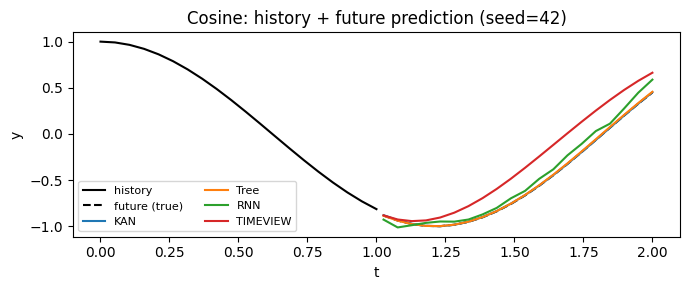

In [97]:
import matplotlib.pyplot as plt

idx = test_idx[5]
t_future = ts[idx]
y_future_true = ys_list[idx]
y_hist = Zs[idx].reshape(-1)
t_hist = np.linspace(0.0, history_end, len(y_hist))

Xb, Zb, Phi, yb = kan_dataset[idx]
with torch.no_grad():
    y_kan = kan_lit.model(Xb.unsqueeze(0), Zb.unsqueeze(0), [Phi])[0].cpu().numpy()

x_in = X_base[idx:idx+1]
y_lin = lin.predict(x_in)[0]
y_tree = tree.predict(x_in)[0]

x_seq = torch.from_numpy(X_seq[idx:idx+1]).float()
with torch.no_grad():
    y_rnn = rnn(x_seq).cpu().numpy()[0]

Xb_tts, Phi_tts, yb_tts = tts_dataset[idx]
tts_lit.model.eval()
with torch.no_grad():
    y_tts = tts_lit.model(Xb_tts.unsqueeze(0), [Phi_tts])[0].cpu().numpy()

plt.figure(figsize=(7, 3))
plt.plot(t_hist, y_hist, 'k-', label='history')
plt.plot(t_future, y_future_true, 'k--', label='future (true)')
plt.plot(t_future, y_kan, label='KAN')
#plt.plot(t_future, y_lin, label='Linear')
plt.plot(t_future, y_tree, label='Tree')
plt.plot(t_future, y_rnn, label='RNN')
plt.plot(t_future, y_tts, label='TIMEVIEW')
plt.title('Cosine: history + future prediction (seed=42)')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


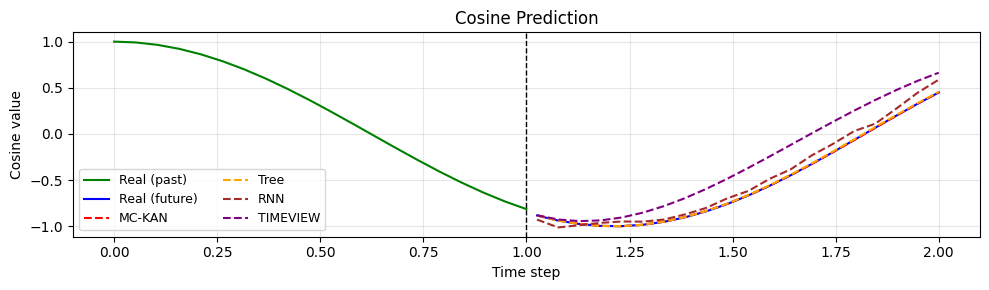

In [98]:
plt.figure(figsize=(10, 3))

plt.plot(
    t_hist,
    y_hist,
    color='green',
    linewidth=1.5,
    label='Real (past)'
)

plt.plot(
    t_future,
    y_future_true,
    color='blue',
    linewidth=1.5,
    label='Real (future)'
)

plt.plot(
    t_future,
    y_kan,
    color='red',
    linestyle='--',
    linewidth=1.5,
    label='MC-KAN'
)

plt.plot(
    t_future,
    y_tree,
    color='orange',
    linestyle='--',
    linewidth=1.5,
    label='Tree'
)

plt.plot(
    t_future,
    y_rnn,
    color='brown',
    linestyle='--',
    linewidth=1.5,
    label='RNN'
)

plt.plot(
    t_future,
    y_tts,
    color='purple',
    linestyle='--',
    linewidth=1.5,
    label='TIMEVIEW'
)

plt.axvline(
    1,
    color='black',
    linestyle='--',
    linewidth=1
)

plt.xlabel('Time step')
plt.ylabel('Cosine value')
plt.title('Cosine Prediction')
plt.legend(loc='lower left', fontsize=9, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cos1.png', bbox_inches='tight')
plt.show()

/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/kan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/kan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  input_range = torch.std(preacts, dim=0) + 0.1
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/kan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally 

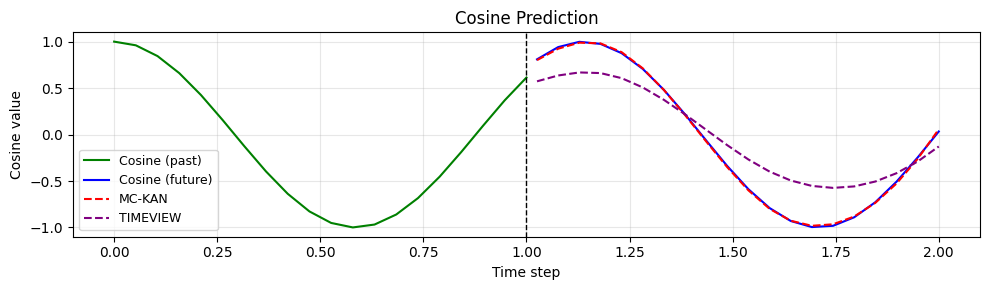

In [99]:
import matplotlib.pyplot as plt

idx = test_idx[4]
t_future = ts[idx]
y_future_true = ys_list[idx]
y_hist = Zs[idx].reshape(-1)
t_hist = np.linspace(0.0, history_end, len(y_hist))

Xb, Zb, Phi, yb = kan_dataset[idx]
with torch.no_grad():
    y_kan = kan_lit.model(Xb.unsqueeze(0), Zb.unsqueeze(0), [Phi])[0].cpu().numpy()

x_in = X_base[idx:idx+1]
y_lin = lin.predict(x_in)[0]
y_tree = tree.predict(x_in)[0]

x_seq = torch.from_numpy(X_seq[idx:idx+1]).float()
with torch.no_grad():
    y_rnn = rnn(x_seq).cpu().numpy()[0]

Xb_tts, Phi_tts, yb_tts = tts_dataset[idx]
tts_lit.model.eval()
with torch.no_grad():
    y_tts = tts_lit.model(Xb_tts.unsqueeze(0), [Phi_tts])[0].cpu().numpy()

plt.figure(figsize=(10, 3))

plt.plot(
    t_hist,
    y_hist,
    color='green',
    linewidth=1.5,
    label='Cosine (past)'
)

plt.plot(
    t_future,
    y_future_true,
    color='blue',
    linewidth=1.5,
    label='Cosine (future)'
)

plt.plot(
    t_future,
    y_kan,
    color='red',
    linestyle='--',
    linewidth=1.5,
    label='MC-KAN'
)

plt.plot(
    t_future,
    y_tts,
    color='purple',
    linestyle='--',
    linewidth=1.5,
    label='TIMEVIEW'
)

plt.axvline(
    1,
    color='black',
    linestyle='--',
    linewidth=1
)

plt.xlabel('Time step')
plt.ylabel('Cosine value')
plt.title('Cosine Prediction')
plt.legend(loc='lower left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cos2.png', bbox_inches='tight')
plt.show()
